In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [ ]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))  # Rescale pixel values to 0-1 range
])
# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

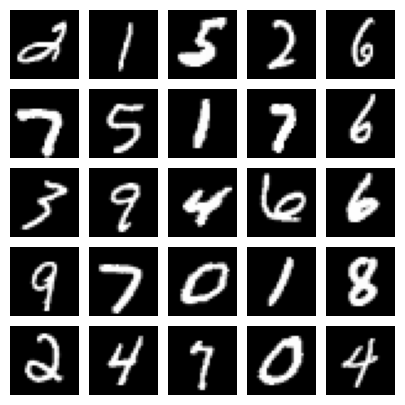

In [ ]:
image = next(iter(train_loader))


num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [ ]:
from torch.optim import Adam
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
def loss_fun(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [ ]:
from tqdm import tqdm
def train(model, optimizer, epochs, device,x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0

        for batch_idx, (x, _) in enumerate(tqdm(train_loader)):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_fun(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=50, device=device)


In [ ]:
print(model.encoder)
latent_dim=2

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=400, out_features=200, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
)


In [ ]:
torch.save(model.state_dict(), 'vae_model1.pth')


In [ ]:
model.load_state_dict(torch.load('vae_model.pth'))

# Set the model to evaluation mode
model.eval()
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=200, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
import torch.distributions as dist

def generate_samples(n_samples, latent_dist="normal",alpha=1.0,beta=1.0,rate=None):

    with torch.no_grad():
        if latent_dist == "normal":
            z = torch.randn(n_samples, latent_dim).to(device)
        elif latent_dist == "gaussian":
            mu = torch.ones(n_samples, latent_dim).to(device)
            logvar = torch.ones(n_samples, latent_dim).fill_(2).to(device)  # Gaussian (1, 2)
            z = model.reparameterization(mu, logvar)
        elif latent_dist == "beta":
            alpha = torch.ones(n_samples, latent_dim).to(device)*alpha  # Shape parameter
            beta = torch.ones(n_samples, latent_dim).to(device)*beta  # Shape parameter
            beta_dist = dist.Beta(alpha, beta)
            z = beta_dist.sample()
        elif latent_dist == "gamma":
            if rate is None:
                raise ValueError("Rate parameter 'rate' must be specified for Gamma distribution.")
            concentration = torch.ones(n_samples, latent_dim).to(device) * alpha  # Shape parameter
            rate = torch.ones(n_samples, latent_dim).to(device) * rate
            gamma_dist = dist.Gamma(concentration, rate)
            z = gamma_dist.sample()
        else:
            raise ValueError(f"Unsupported latent distribution: {latent_dist}")
        return z

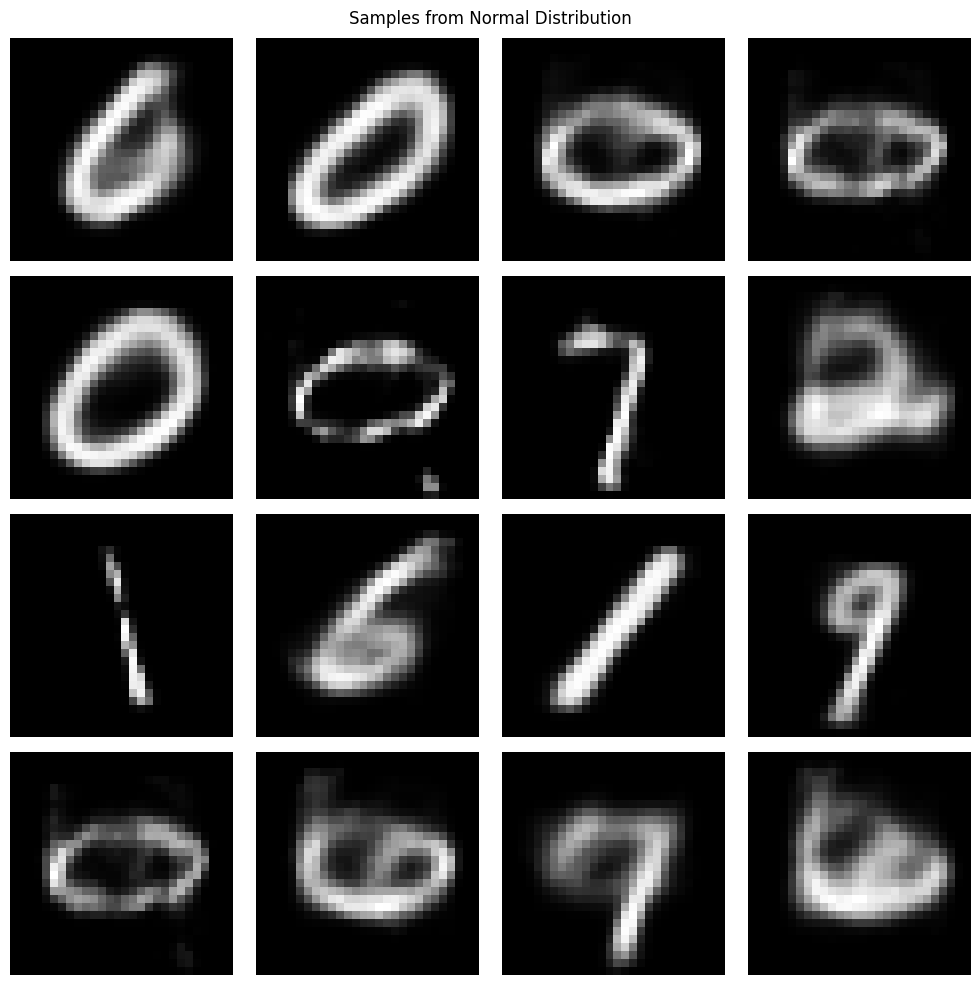

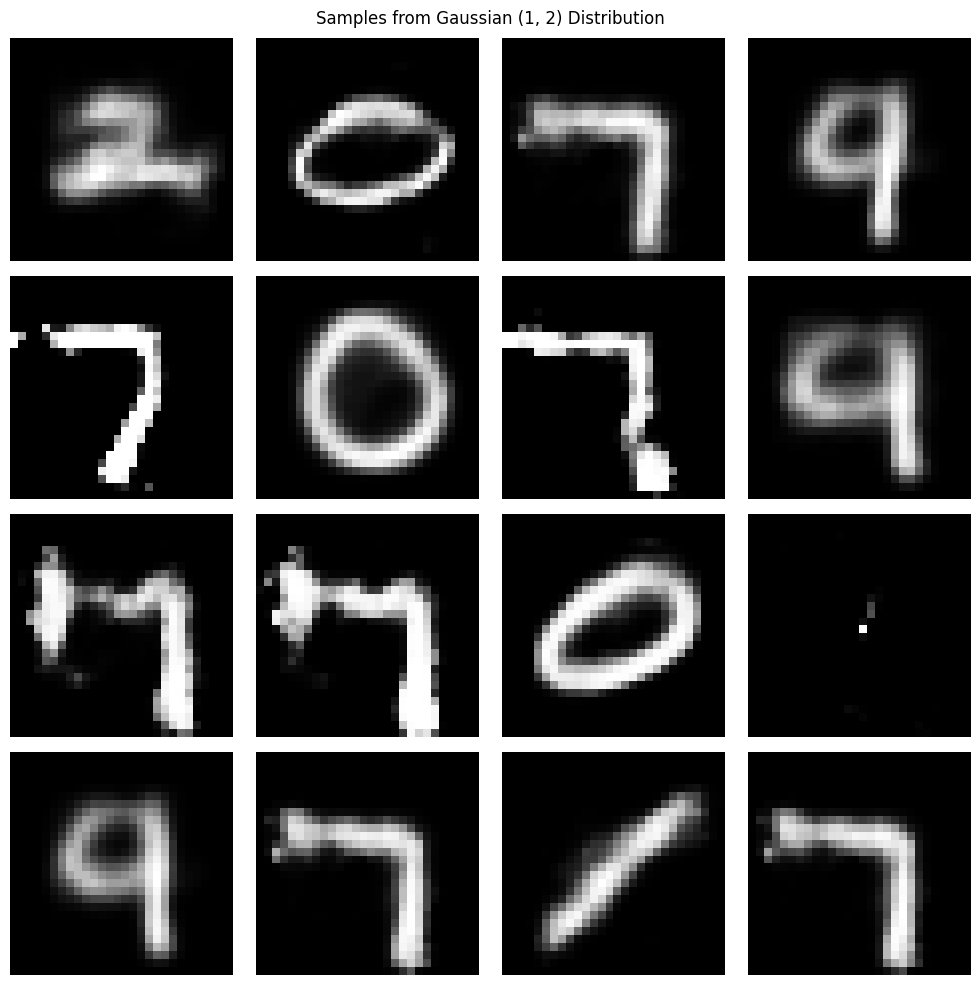

In [ ]:
normal_samples = generate_samples(16, latent_dist="normal")
gaussian_samples = generate_samples(16, latent_dist="gaussian")

# Decode the generated samples
with torch.no_grad():
    normal_decoded = model.decoder(normal_samples)
    gaussian_decoded = model.decoder(gaussian_samples)
    normal_decoded = normal_decoded.view(-1, 28, 28)  # Reshape to (batch_size, 28, 28)
    gaussian_decoded = gaussian_decoded.view(-1, 28, 28)

# Qualitative comparison (using visualization)
import matplotlib.pyplot as plt

# Create a grid to visualize samples
grid_size = 4
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Display normal samples
for i in range(grid_size):
    for j in range(grid_size):
        axes[i, j].imshow(normal_decoded[i * grid_size + j].cpu().squeeze(), cmap='gray')
        axes[i, j].axis('off')
fig.suptitle('Samples from Normal Distribution', fontsize=12)
plt.tight_layout()
plt.show()

# Repeat for Gaussian (1, 2) samples
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
# Display normal samples
for i in range(grid_size):
    for j in range(grid_size):
        axes[i, j].imshow(gaussian_decoded[i * grid_size + j].cpu().squeeze(), cmap='gray')
        axes[i, j].axis('off')
# ... (repeat the visualization process for gaussian_decoded)
fig.suptitle('Samples from Gaussian (1, 2) Distribution', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
beta_samples = generate_samples(16, latent_dist="beta",alpha=0.5,beta=1.0)
len(beta_samples)

16

In [ ]:
def visualise(beta_samples,model):
  sample_idx = 0
  grid_size = int(np.ceil(np.sqrt(len(beta_samples))))
  print(f"gridsize={grid_size}")
  # Repeat for Gaussian (1, 2) samples
  with torch.no_grad():
    beta_decoded = model.decoder(beta_samples)
    beta_decoded = beta_decoded.view(-1, 28, 28)
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))
  # Display normal samples
  for i in range(grid_size):
      for j in range(grid_size):
          if sample_idx < len(beta_samples):
              axes[i, j].imshow(beta_decoded[sample_idx].cpu().squeeze(), cmap='gray')
              axes[i, j].axis('off')
              sample_idx += 1
          else:
              axes[i, j].axis('off')
  # ... (repeat the visualization process for gaussian_decoded)
  fig.suptitle('Samples from beta', fontsize=12)
  plt.tight_layout()
  plt.show()

gridsize=4


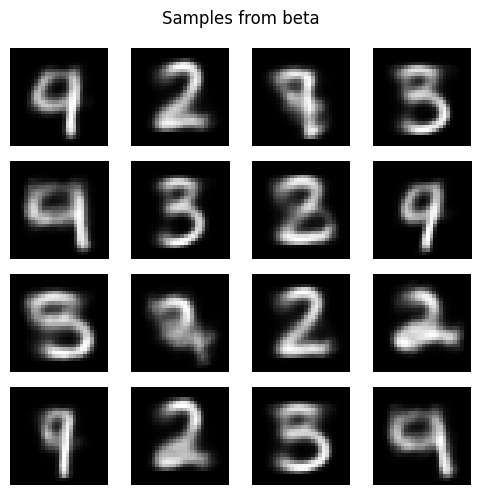

In [ ]:
# @title
visualise(beta_samples,model)


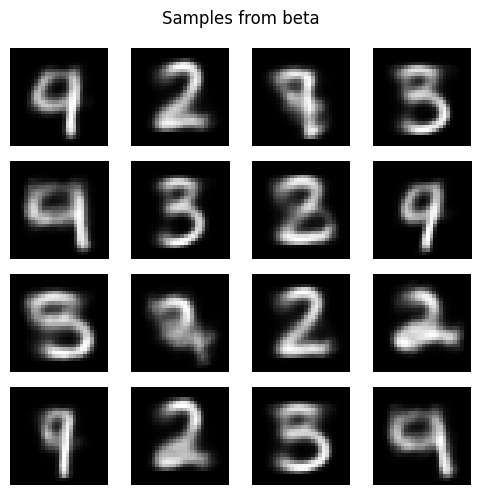

In [ ]:
# @title

# Decode the generated samples
with torch.no_grad():
    beta_decoded = model.decoder(beta_samples)
    beta_decoded = beta_decoded.view(-1, 28, 28)

# Qualitative comparison (using visualization)
import matplotlib.pyplot as plt

# Create a grid to visualize samples
sample_idx = 0

# Repeat for Gaussian (1, 2) samples
fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))
# Display normal samples
for i in range(grid_size):
    for j in range(grid_size):
         if sample_idx < len(beta_samples):
            axes[i, j].imshow(beta_decoded[sample_idx].cpu().squeeze(), cmap='gray')
            axes[i, j].axis('off')
            sample_idx += 1
         else:
            axes[i, j].axis('off')
# ... (repeat the visualization process for gaussian_decoded)
fig.suptitle('Samples from beta', fontsize=12)
plt.tight_layout()
plt.show()

a=1.1,b=1.1
gridsize=2


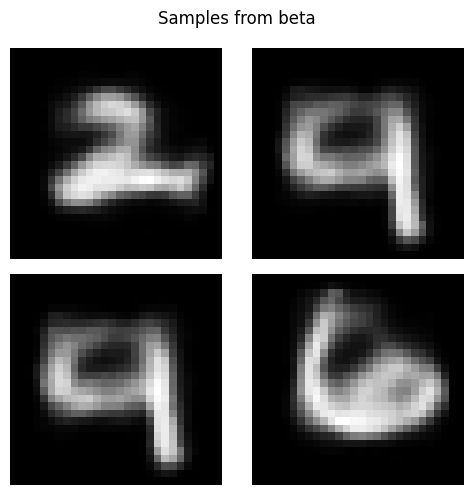

a=1.1,b=2.0
gridsize=2


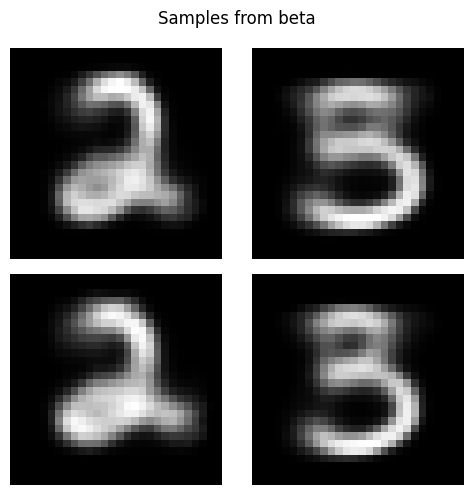

a=1.1,b=3.0
gridsize=2


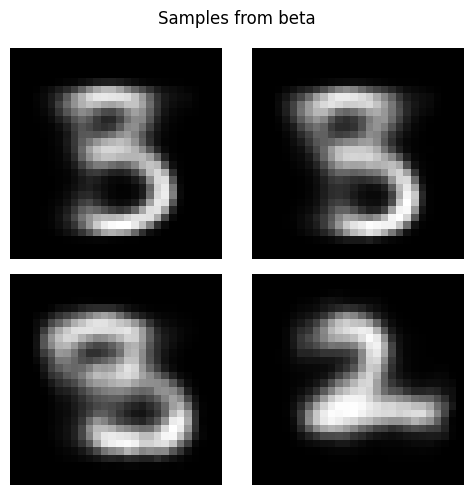

a=1.1,b=4.0
gridsize=2


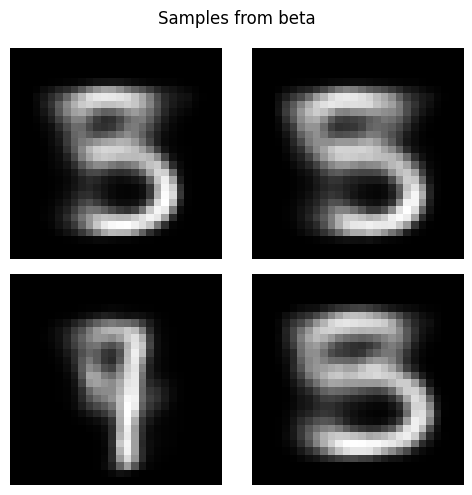

a=1.1,b=5.0
gridsize=2


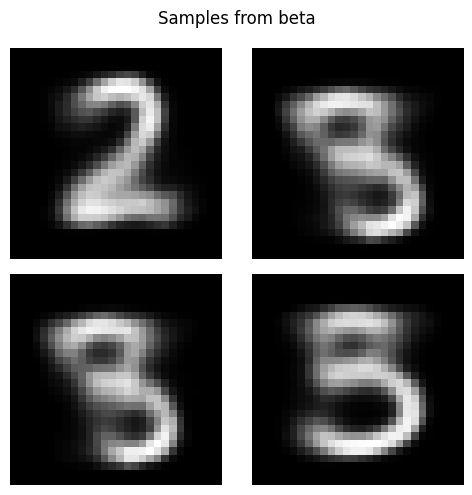

a=2.0,b=1.1
gridsize=2


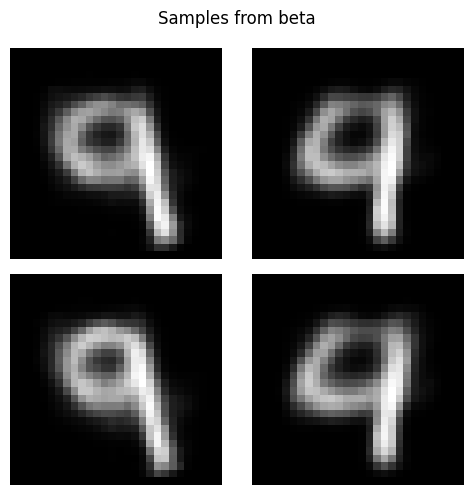

a=2.0,b=2.0
gridsize=2


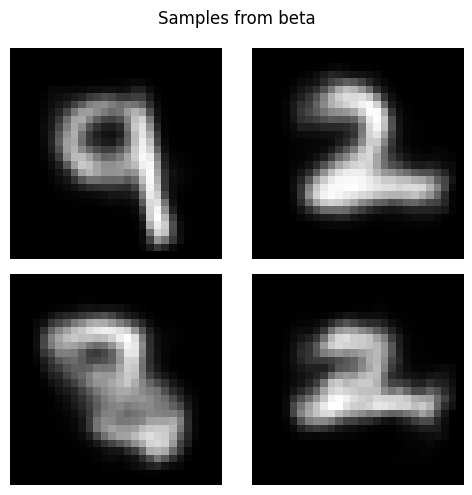

a=2.0,b=3.0
gridsize=2


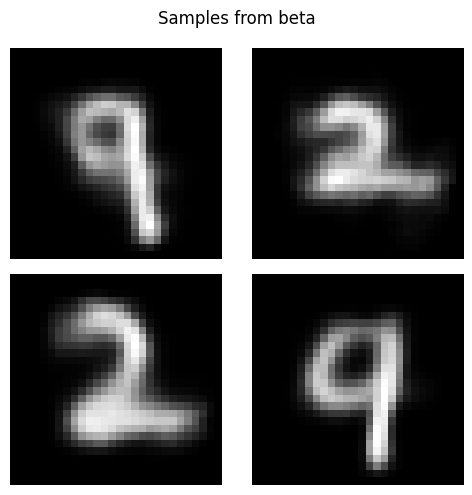

a=2.0,b=4.0
gridsize=2


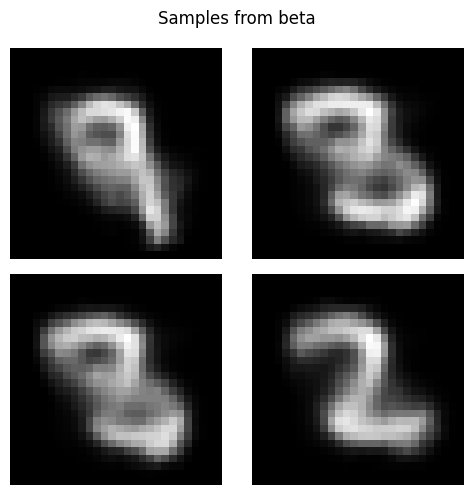

a=2.0,b=5.0
gridsize=2


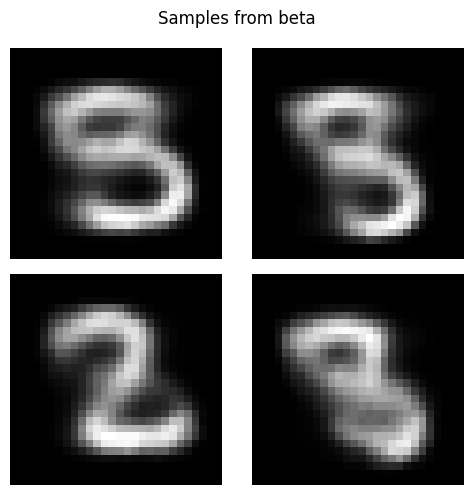

a=3.0,b=1.1
gridsize=2


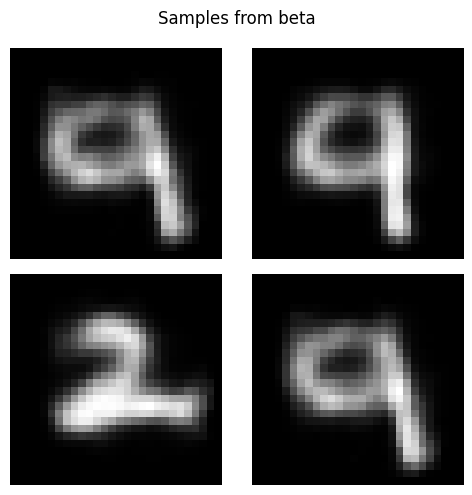

a=3.0,b=2.0
gridsize=2


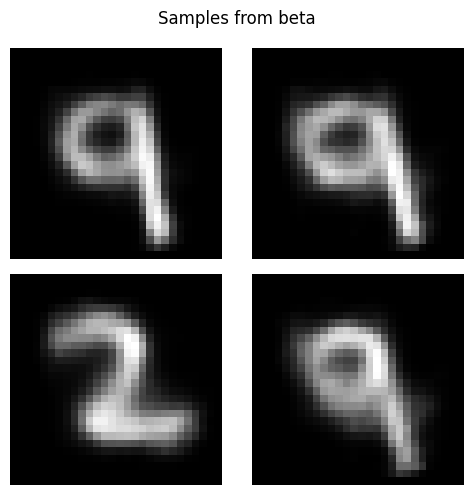

a=3.0,b=3.0
gridsize=2


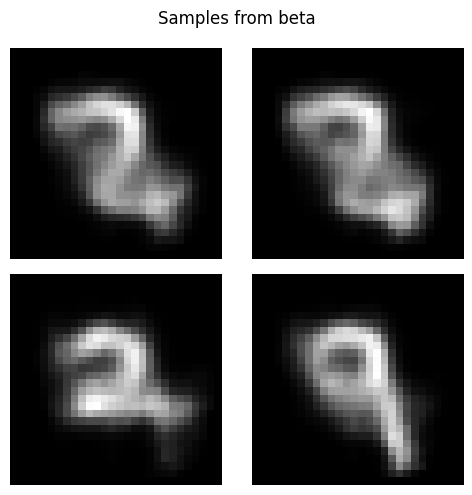

a=3.0,b=4.0
gridsize=2


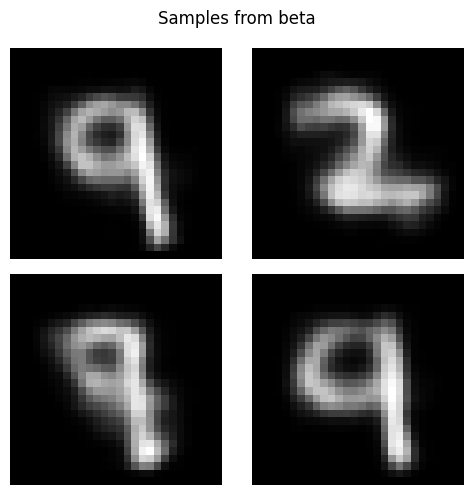

a=3.0,b=5.0
gridsize=2


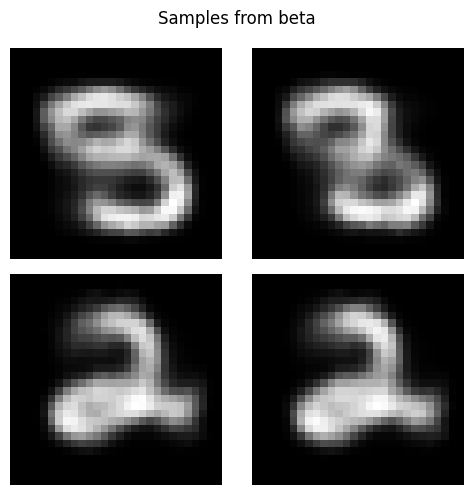

a=4.0,b=1.1
gridsize=2


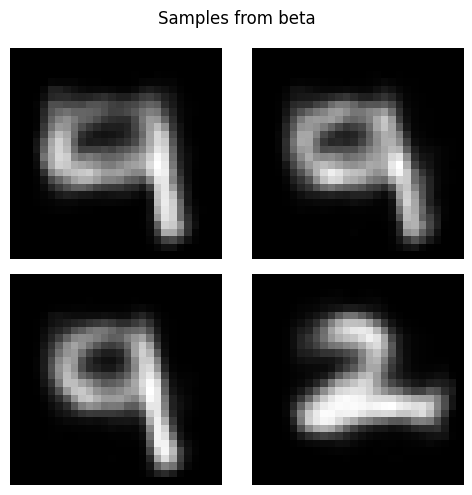

a=4.0,b=2.0
gridsize=2


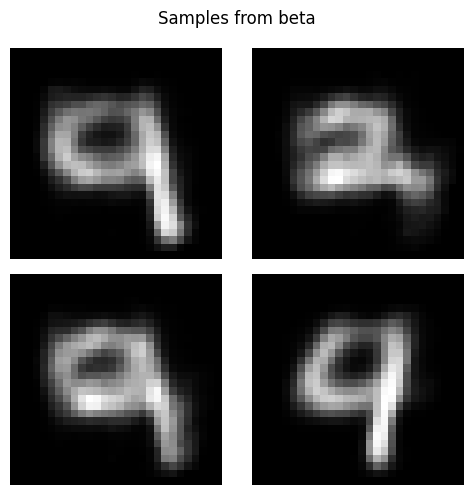

a=4.0,b=3.0
gridsize=2


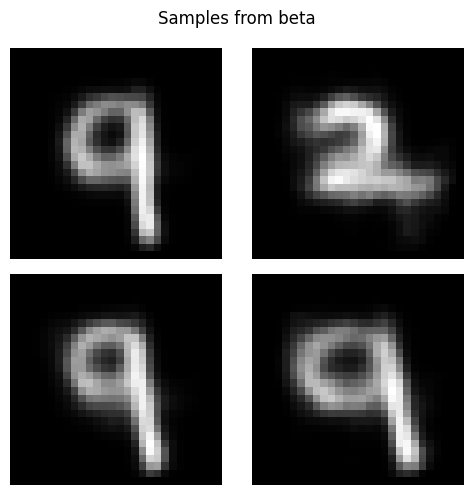

a=4.0,b=4.0
gridsize=2


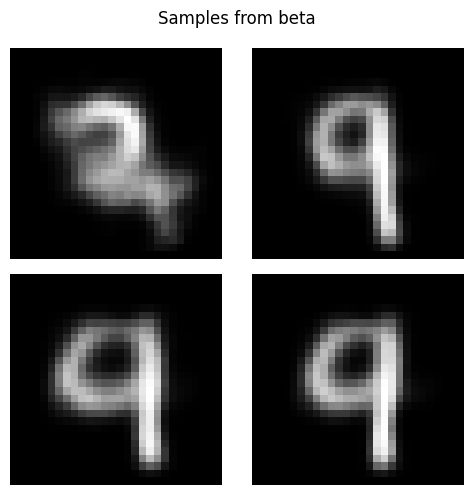

a=4.0,b=5.0
gridsize=2


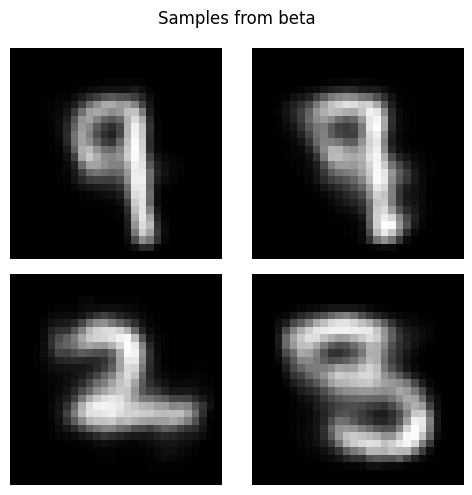

a=5.0,b=1.1
gridsize=2


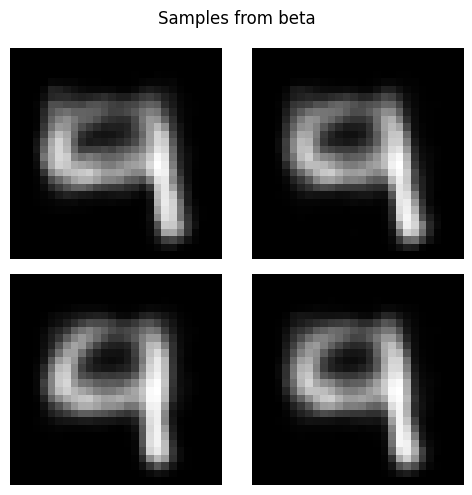

a=5.0,b=2.0
gridsize=2


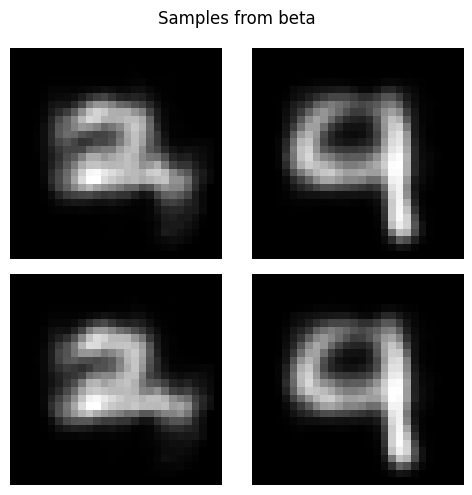

a=5.0,b=3.0
gridsize=2


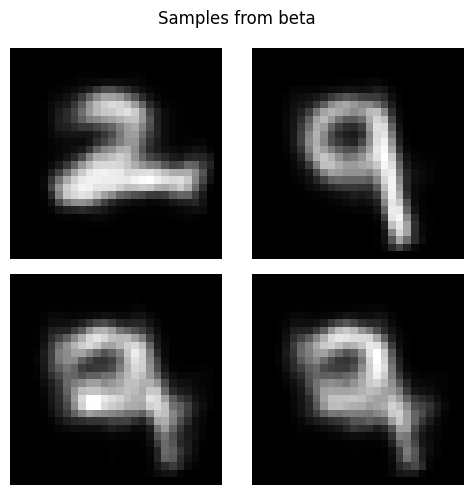

a=5.0,b=4.0
gridsize=2


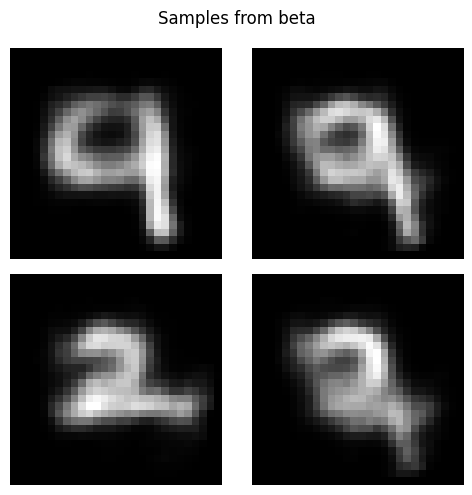

a=5.0,b=5.0
gridsize=2


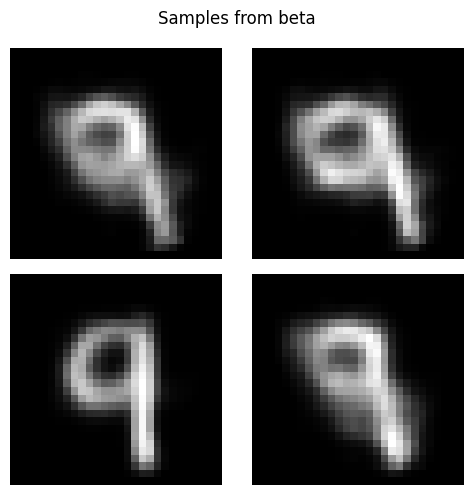

In [ ]:
# @title

for alpha in [1.1,2.0,3.0,4.0,5.0]:
  for beta in  [1.1,2.0,3.0,4.0,5.0]:
    print(f"a={alpha},b={beta}")
    betas = generate_samples(4, latent_dist="beta",alpha=alpha,beta=beta)


    visualise(betas,model)



In [ ]:
# @title
import torch
import matplotlib.pyplot as plt

# Define the number of samples
n_samples = 1000

# Define the range for alpha and beta
alpha_range = torch.linspace(0.1, 9.9, steps=10)
beta_range = torch.linspace(0.1, 9.9, steps=10)

# Create a grid of subplots
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

# Iterate over each combination of alpha and beta
for i, alpha in enumerate(alpha_range):
    for j, beta in enumerate(beta_range):
        # Create beta distribution
        beta_dist = torch.distributions.Beta(alpha, beta)
        # Generate samples
        samples = beta_dist.sample((n_samples,))
        # Plot histogram
        axs[i, j].hist(samples.numpy(), bins=30, density=True, alpha=0.6)
        axs[i, j].set_title(f'α={alpha.item():.2f}, β={beta.item():.2f}')
        axs[i, j].set_xticks([0, 0.5, 1])
        axs[i, j].set_yticks([])
        axs[i, j].set_xlim([0, 1])

plt.tight_layout()
plt.show()

In [ ]:
# @title
modelAnneal=VAE().to(device)

In [ ]:
# @title
import matplotlib.pyplot as plt
from tqdm import tqdm

reconstruction_losses = []
divergence_losses = []
kl_weights = []
def train_with_annealing(model, optimizer, epochs, device, x_dim=784, annealing_epochs=10):
    model.train()


    for epoch in range(epochs):
        overall_loss = 0
        kl_weight = min(1.0, (epoch + 1) / annealing_epochs)  # Annealing schedule for KL weight

        for batch_idx, (x, _) in enumerate(tqdm(train_loader)):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
            kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

            loss = reconstruction_loss + kl_weight * kl_divergence

            overall_loss += loss.item()

            # Append values to the lists
            reconstruction_losses.append(reconstruction_loss.item())
            divergence_losses.append(kl_divergence.item())
            kl_weights.append(kl_weight)


            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))

    # Plot the values
    plot_values(reconstruction_losses, divergence_losses, kl_weights)

    return overall_loss

def plot_values(reconstruction_losses, divergence_losses, kl_weights):
    epochs = len(reconstruction_losses)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), reconstruction_losses, label='Reconstruction Loss')
    plt.plot(range(1, epochs + 1), divergence_losses, label='Divergence Loss')
    plt.plot(range(1, epochs + 1), kl_weights, label='KL Weight')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Weight')
    plt.title('Reconstruction Loss, Divergence Loss, and KL Weight per Epoch')
    plt.legend()
    plt.show()

# Train the model with KL divergence annealing
train_with_annealing(modelAnneal, optimizer, epochs=10, device=device, annealing_epochs=10)


100%|██████████| 600/600 [00:28<00:00, 21.23it/s]


	Epoch 1 	Average Loss:  544.938629225793


100%|██████████| 600/600 [00:27<00:00, 21.47it/s]


	Epoch 2 	Average Loss:  544.9390068082221


 66%|██████▌   | 393/600 [00:17<00:09, 21.96it/s]


KeyboardInterrupt: 

1593 1593 1593


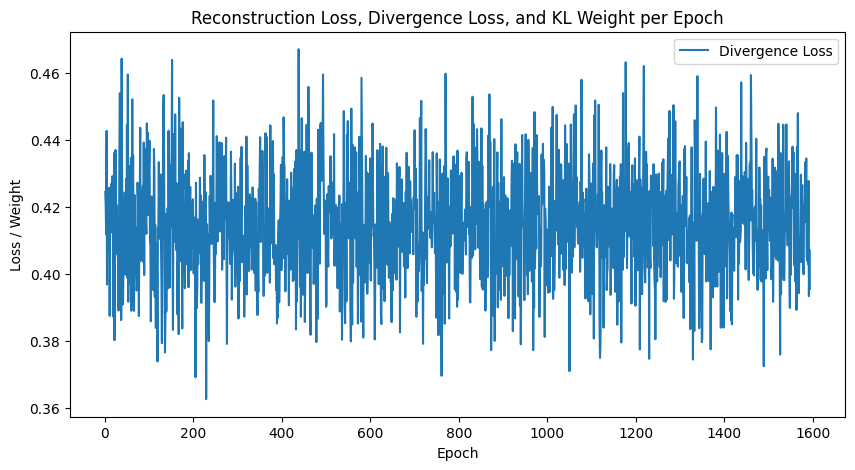

In [ ]:
# @title

def plot_values(reconstruction_losses, divergence_losses, kl_weights):
    epochs = len(reconstruction_losses)
    plt.figure(figsize=(10, 5))
    #plt.plot(range(1, len(reconstruction_losses)+1), reconstruction_losses, label='Reconstruction Loss')
    plt.plot(range(1, len(reconstruction_losses)+1), divergence_losses, label='Divergence Loss')
    #plt.plot(range(1,len(reconstruction_losses)+1), kl_weights, label='KL Weight')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Weight')
    plt.title('Reconstruction Loss, Divergence Loss, and KL Weight per Epoch')
    plt.legend()
    plt.show()
print(len(reconstruction_losses),len(divergence_losses),len(kl_weights))
plot_values(reconstruction_losses, divergence_losses, kl_weights)


In [ ]:
# @title
torch.save(model.state_dict(), 'vae_model_annealed.pth')


In [ ]:
# @title
modelAnneal.load_state_dict(torch.load('vae_model_annealed.pth'))

# Set the model to evaluation mode
modelAnneal.eval()
print(modelAnneal)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
  )
  (mean_layer): Linear(in_features=200, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=200, out_features=400, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=400, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
latent_dim=2

a=1.1,b=1.1
gridsize=2


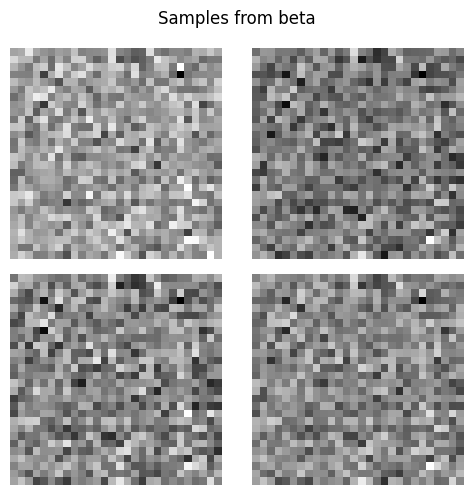

a=1.1,b=2.0
gridsize=2


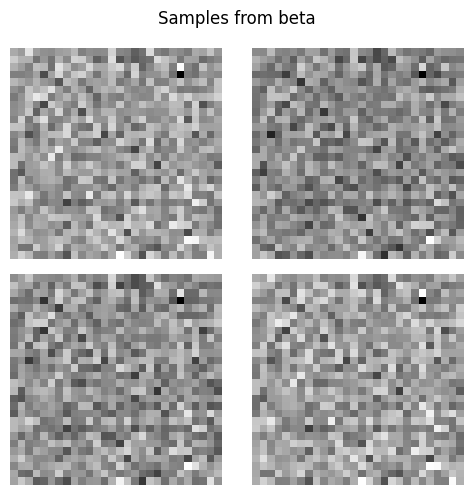

a=1.1,b=3
gridsize=2


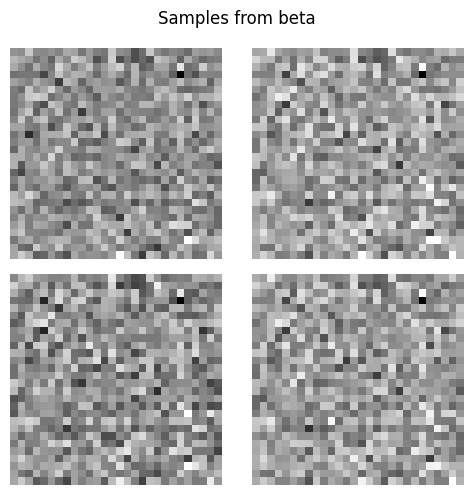

a=4.0,b=1.1
gridsize=2


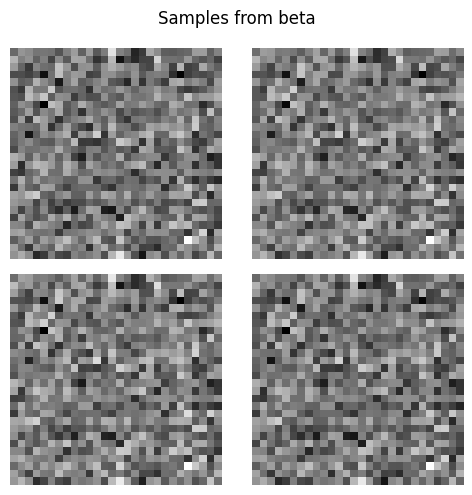

a=4.0,b=2.0
gridsize=2


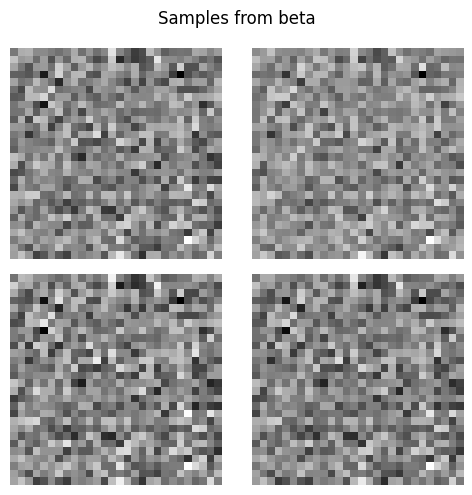

a=4.0,b=3
gridsize=2


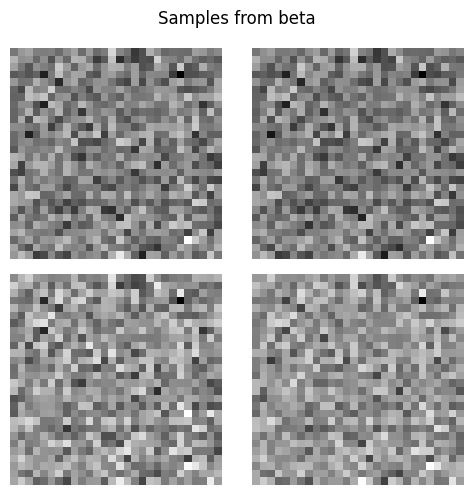

In [ ]:
for alpha in [1.1,4.0]:
  for beta in  [1.1,2.0,3]:
    print(f"a={alpha},b={beta}")
    betas = generate_samples(4, latent_dist="beta",alpha=alpha,beta=beta)


    visualise(betas,model  )
